<a href="https://colab.research.google.com/github/Schimmenti/EarthquakesGPS/blob/main/Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import time
from scipy.ndimage.filters import maximum_filter1d, minimum_filter1d
from google.colab import drive
from sklearn.metrics import roc_curve
drive.mount('/content/drive', force_remount=True)
from sklearn.neighbors import  KDTree,BallTree

Mounted at /content/drive


# Utils

In [38]:
def max_filter1d_valid(a, W, add_heading_nan=True):
    hW = (W-1)//2 # Half window size
    if(add_heading_nan):
      if(W%2==1):
        return np.concatenate([np.ones(W-1)*np.nan,maximum_filter1d(a,size=W)[hW:-hW]])
      else:
        return np.concatenate([np.ones(W-2)*np.nan,maximum_filter1d(a,size=W)[hW:-hW]])
    else:
      return maximum_filter1d(a,size=W)[hW:-hW]
def min_filter1d_valid(a, W, add_heading_nan=True):
    hW = (W-1)//2 # Half window size
    if(add_heading_nan):
      if(W%2==1):
        return np.concatenate([np.ones(W-1)*np.nan,minimum_filter1d(a,size=W)[hW:-hW]])
      else:
        return np.concatenate([np.ones(W-2)*np.nan,minimum_filter1d(a,size=W)[hW:-hW]])
    else:
      return minimum_filter1d(a,size=W)[hW:-hW]

In [39]:
def haversine(lat1, lat2, delta_long):
  return np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(delta_long/2)**2

In [40]:
def moving_lin_regress(x, T, t0, t1, add_heading_nan=True):
    m = []
    for t in range(t0,t1-T):
        m.append(stats.linregress(np.arange(0,T),x[t:t+T])[0])
    if(add_heading_nan):
      return np.concatenate([np.ones(T)*np.nan, np.array(m)])
    else:
      return np.array(m)

# Station Names/Pos

In [41]:
base_link = "https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/"

In [42]:
! wget "https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/stat_info.pkl"

--2022-03-29 20:49:56--  https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/stat_info.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17030 (17K) [application/octet-stream]
Saving to: ‘stat_info.pkl.1’

stat_info.pkl.1     100%[===================>]  16.63K  --.-KB/s    in 0s      

2022-03-29 20:49:56 (33.3 MB/s) - ‘stat_info.pkl.1’ saved [17030/17030]



In [43]:
with open("stat_info.pkl","rb") as handle:
  station_names, station_pos = pkl.load(handle)

# Stations Raw Data

In [55]:
load_stat_raw_data = True
if(load_stat_raw_data):
  with open("drive/MyDrive/Colab Notebooks/stat_data.pkl","rb") as handle:
    stat_data = pkl.load(handle)
else:
  stat_data = {}
  for name in station_names:
    try:
      stat_data[name] = pd.read_csv(base_link + name + ".csv")
    except:
      continue
  for name in stat_data.keys():
    stat_data[name]['Date'] = pd.to_datetime(stat_data[name]['DateI'], format='%Y%m%d')
    stat_data[name].set_index("Date", drop=True, inplace=True)
    idx = pd.date_range(stat_data[name].index[0], stat_data[name].index[-1])
    stat_data[name] = stat_data[name].reindex(idx, fill_value=np.NaN)
  with open("stat_data.pkl", "wb") as handle:
    pkl.dump(stat_data,handle)

# Linear Regression Coefficents

In [56]:
W=9
load_coefs = True
if(load_coefs):
  with open("drive/MyDrive/Colab Notebooks/T_W=%i.pkl"%W,"rb") as handle:
    coefs = pkl.load(handle)
else:
  coefs = {}
  for name in stat_data.keys():
    nord = stat_data[name]["N"].values
    if(len(nord) >= W):
      T_w_nord = moving_lin_regress(nord, W, 0, len(nord))
      east = stat_data[name]["E"].values
      T_w_east = moving_lin_regress(east, W, 0, len(east))
      up = stat_data[name]["U"].values
      T_w_up = moving_lin_regress(up, W, 0, len(up))
      coefs[name] = np.array([T_w_nord, T_w_east, T_w_up])
  with open("T_W=%i.pkl"%W, "wb") as handle:
    pkl.dump(coefs,handle)

# Excursion Coefficents

In [57]:
load_excoefs = True
if(load_excoefs):
  with open("drive/MyDrive/Colab Notebooks/ex_T_W=%i.pkl"%W,"rb") as handle:
    excoefs = pkl.load(handle)
else:
  excoefs = {}
  for key in coefs.keys():
    temp = []
    for el in coefs[key]:
      temp.append(max_filter1d_valid(el, W)-min_filter1d_valid(el, W))
    temp = np.array(temp)
    excoefs[key] = temp
  with open("ex_T_W=%i.pkl" %W, "wb") as handle:
    pkl.dump(excoefs,handle)

# $V_i$ coefficents (cell)

In [60]:
load_v_cell = True
W_cell = W
if(load_v_cell):
  with open("drive/MyDrive/Colab Notebooks/V_W_cell=%i.pkl" %W_cell, "rb") as handle:
    V_cells = pkl.load(handle)
else:
  V_cells = {}
  gammas = np.array([1,1,0])
  for key in excoefs.keys():
    V_day = np.sqrt(np.matmul(gammas,(excoefs[key]**2)))
    if(len(V_day) <= W_cell):
      V_cell = np.ones(W_cell)*np.max(V_day)
      flag = np.zeros(len(V_cell), dtype=int)
      flag[0] = 1
    else:
      V_cell = np.concatenate([ np.max(cell)*np.ones(len(cell)) for cell in np.split(V_day, np.arange(0, len(V_day), W_cell))[1:]])
      flag = np.zeros(len(V_cell), dtype=int)
      flag[np.arange(0, len(V_day), W_cell)] = 1
    s_days = stat_data[key].index.values
    df = pd.DataFrame()
    df["Date"] = s_days
    df["V"] = V_cell
    df["Flag"] = flag
    df.set_index("Date", drop=True, inplace=True)
    V_cells[key] = df
  with open("V_W_cell=%i.pkl" %W_cell, "wb") as handle:
    pkl.dump(V_cells,handle)

# $V_i$ coefficents (day)

In [ ]:
W_max=W
V_ws = {}
for key in excoefs.keys():
  V = np.sqrt(np.sum(excoefs[key][:2,:]**2,axis=0))
  if(len(V) <= W_max):
    V_windowed = V
  else:
    V_windowed = max_filter1d_valid(V, W_max)
  s_days = stat_data[key].index.values
  df = pd.DataFrame()
  df["Date"] = s_days
  df["V"] = V_windowed
  df.set_index("Date", drop=True, inplace=True)
  V_ws[key] = df
  if(len(s_days)!=excoefs[key].shape[1]):
    print("Sheit")

In [ ]:
with open("V_W=%i.pkl" %W_max, "wb") as handle:
  pkl.dump(V_ws,handle)

# Earthquake catalogs

In [61]:
def download_catalog(catalog_name):
  earthquakes = pd.read_csv("https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/%s" % catalog_name, sep="\s+", header=None, names=["year","month","day", "hh","mn","ss","lat","long","dep","m"])
  earthquakes["long"] = -earthquakes["long"]
  earthquakes["Date"] =pd.to_datetime(earthquakes[['year','month','day']])
  earthquakes.set_index("Date",inplace=True)
  return earthquakes

def download_catalog_hauksson():
  catalog = pd.read_csv("https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/hauksson_relocated.dat",sep=r"\s+",header=None)
  catalog.columns = ["sec","m","lat","long","dep"]
  landers = catalog[catalog["m"]==7.3]
  landers_date = datetime.date(1992,6,28)
  landers_time = datetime.timedelta(hours=11, minutes=57, seconds=33)
  delta_time = datetime.timedelta(seconds=float(landers['sec'].values))
  catalog_beginning = landers_date+landers_time-delta_time
  catalog_seconds = catalog['sec'].values.astype('timedelta64[s]')
  start_date = np.datetime64(catalog_beginning)
  catalog_dates = start_date + catalog_seconds
  year_integer =  catalog_dates.astype('datetime64[Y]').astype('int')+1970
  month_integer =  catalog_dates.astype('datetime64[M]').astype('int')%12+1
  day_integer = (catalog_dates- catalog_dates.astype('datetime64[M]') + 1).astype('timedelta64[D]').astype('int')+1
  date_integer =(year_integer*10000+month_integer*100+day_integer)
  pandas_datetime = pd.to_datetime(date_integer, format='%Y%m%d')
  catalog["Date"] = pandas_datetime
  catalog.set_index("Date", drop=True, inplace=True)
  #catalog.to_csv("catalog.csv", sep="\t")
  return catalog

In [62]:
catalog_big = download_catalog("sc_4.5_tutti_9w.dat")
catalog_small = download_catalog("sc_schifezze.dat")

# Station Position vs Earthquakes (depends on prev. cell)

In [63]:
position_array = np.array([station_pos[key] for key in excoefs.keys()])
lat1 = catalog_big['lat'].values.reshape(-1,1)
lat2 = position_array[:,0].reshape(1,-1)
delta_long = catalog_big['long'].values.reshape(-1,1)-position_array[:,1].reshape(1,-1)
distances_big = haversine(lat1,lat2,delta_long)
ord_dist_big = np.argsort(distances_big, axis=1)
lat1 = catalog_small['lat'].values.reshape(-1,1)
delta_long = catalog_small['long'].values.reshape(-1,1)-position_array[:,1].reshape(1,-1)
distances_small = haversine(lat1,lat2,delta_long)
ord_dist_small = np.argsort(distances_big, axis=1)

In [67]:
station_keys_array = np.array(list(excoefs.keys()))
max_distance = 1e-2
vth_probs = np.linspace(0,1,50)
single_alarm = np.zeros_like(vth_probs)
for cnt, (date,row) in enumerate(catalog_big.iterrows()):
  closeness_idx = 0
  while(True and closeness_idx < len(ord_dist_big[cnt,:])):
    closest_station = station_keys_array[ord_dist_big[cnt,closeness_idx]]
    final_distance = distances_big[cnt,ord_dist_big[cnt,closeness_idx]]
    df = V_cells[closest_station]
    match = df[np.logical_and(df.index >= date - np.timedelta64(W_cell+1,'D'),df.index <= date  )]
    if(not match.empty):
      if(np.isfinite(match["V"].values).all()):
          vals = match["V"].values
          flags = match["Flag"].values.astype('int')
          flags_where = np.argwhere(flags==1).flatten()
          if(len(flags_where) == 2):
            prev_val =  vals[flags_where[0]]
          else:
            prev_val =  vals[flags_where[0]-1]
          print(prev_val)
          print(match)
          break
      else:
        closeness_idx += 1
    else:
      closeness_idx += 1

1.100491052010671
                   V  Flag
Date                      
1999-05-04  0.851681     0
1999-05-05  1.100491     1
1999-05-06  1.100491     0
1999-05-07  1.100491     0
1999-05-08  1.100491     0
1999-05-09  1.100491     0
1999-05-10  1.100491     0
1999-05-11  1.100491     0
1999-05-12  1.100491     0
1999-05-13  1.100491     0
1999-05-14  1.007354     1
0.8791868086160327
                   V  Flag
Date                      
1999-05-22  0.879187     0
1999-05-23  0.879187     0
1999-05-24  0.879187     0
1999-05-25  0.879187     0
1999-05-26  0.879187     0
1999-05-27  0.879187     0
1999-05-28  0.879187     0
1999-05-29  0.879187     0
1999-05-30  0.654438     1
1999-05-31  0.654438     0
1999-06-01  0.654438     0
0.9893839272777556
                   V  Flag
Date                      
1999-07-22  0.989384     0
1999-07-23  0.989384     0
1999-07-24  0.989384     0
1999-07-25  0.989384     0
1999-07-26  0.989384     0
1999-07-27  0.989384     0
1999-07-28  1.035510     1

# Loading

In [37]:
W=9
W_max = W


with open("drive/MyDrive/Colab Notebooks/V_W=%i.pkl"%W_max,"rb") as handle:
  V_ws = pkl.load(handle)

# Clustering

In [39]:
position_array = np.array([station_pos[key] for key in V_ws.keys()])
pos_rads = position_array*np.pi/180
pos_tree = BallTree(pos_rads, metric="haversine")
distance_threshold = 5e-3

In [40]:
clusters = {}
s_keys = np.array(list(V_ws.keys()))
for idx in range(0,len(pos_rads)):
  query_res = pos_tree.query_radius(pos_rads[idx:idx+1],distance_threshold )[0]
  clusters[s_keys[idx]] = list(s_keys[query_res])

# Alert probability

In [46]:
vth_probs = np.linspace(0,1,50)
earthquake_cnt = 0
alarm = np.zeros_like(vth_probs)
station_keys_array = np.array(list(clusters.keys()))
for cnt, (date,row) in enumerate(earthquakes.iterrows()):
    closeness_idx = 0
    earthquake_alarm = np.zeros_like(vth_probs)
    n_matches = 0
    while(True and closeness_idx < len(closest_station_idx[cnt,:])):
      closest_station = station_keys_array[closest_station_idx[cnt,closeness_idx]]
      final_distance = distances[cnt,closest_station_idx[cnt,closeness_idx]]
      if(final_distance <= distance_threshold):
        for key in clusters[closest_station]:
          match = V_ws[key][V_ws[key].index==date-np.timedelta64(1,'D')]

          if((not match.empty) and np.isfinite(match["V"].values).all()):          
            V_wind = V_ws[key]["V"].values
            V_wind = np.sort(V_wind[np.isfinite(V_wind)])
            vth_indices = np.minimum(np.maximum((1-vth_probs)*len(V_wind), 0), len(V_wind)-1).astype('int')
            vth = V_wind[vth_indices]
            earthquake_alarm += np.heaviside(match["V"].values.flatten()-vth,1)
            n_matches += 1
            
              
      if(n_matches > 0):
        earthquake_cnt += 1
        alarm += np.heaviside(earthquake_alarm,0)
        break
      else:
        closeness_idx+=1
alarm /= earthquake_cnt

In [61]:
vth_probs = np.linspace(0,1,50)
earthquake_cnt = 0
single_alarm = np.zeros_like(vth_probs)
station_keys_array = np.array(list(clusters.keys()))
dist_from_signal = []
for cnt, (date,row) in enumerate(earthquakes.iterrows()):
    closeness_idx = 0
    earthquake_alarm = np.zeros_like(vth_probs)
    found_station = False
    while(True and closeness_idx < len(closest_station_idx[cnt,:])):
      closest_station = station_keys_array[closest_station_idx[cnt,closeness_idx]]
      match = V_ws[closest_station][V_ws[closest_station].index==date-np.timedelta64(1,'D')]
      if((not match.empty) and np.isfinite(match["V"].values).all()):          
        V_wind = V_ws[closest_station]["V"].values
        V_wind = np.sort(V_wind[np.isfinite(V_wind)])
        vth_indices = np.minimum(np.maximum((1-vth_probs)*len(V_wind), 0), len(V_wind)-1).astype('int')
        vth = V_wind[vth_indices]
        single_alarm += np.heaviside(match["V"].values.flatten()-vth,1)
        found_station = True    
      if(found_station):
        dist_from_signal.append(distances[cnt,closest_station_idx[cnt,closeness_idx]])
        earthquake_cnt += 1
        break
      else:
        closeness_idx+=1
single_alarm /= earthquake_cnt
dist_from_signal = np.array(dist_from_signal)

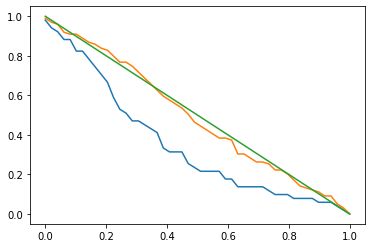

In [64]:
plt.plot(vth_probs,1-alarm)
plt.plot(vth_probs,1-single_alarm)
plt.plot(vth_probs, 1-vth_probs)

# Classification

In [ ]:
vth_posterior = {}
vth_probs = np.linspace(0,1,15)
for key in excoefs.keys():
  V = np.sqrt(np.sum(excoefs[key][:2,:]**2,axis=0))
  V_windowed = max_filter1d_valid(V, W)
  V_windowed = V_windowed[np.isfinite(V_windowed)]
  if(len(V_windowed)>0):
    vth_indices = np.maximum(np.minimum(((1-vth_probs)*len(V_windowed)).astype('int'), len(V_windowed)-1), 0)
    vth_posterior[key] = V_windowed[vth_indices]
  else:
    vth_posterior[key] = np.ones(len(vth_probs))*np.nan

In [ ]:
threshold_dist = 5e-2
res = []
for cnt, (date,row) in enumerate(earthquakes.iterrows()):
  alerts = np.zeros_like(vth_probs)
  matches = np.zeros_like(vth_probs)
  for cnt2, key in enumerate(excoefs.keys()):
     dist = distances[cnt,cnt2]
     if(dist <= threshold_dist):
       match = np.argwhere(stat_data[key].index==date).flatten()
       if(len(match)>0):
         match = match[0]
         matches += 1
         v_matched = np.sqrt(np.sum(excoefs[key][:,match-W:match][:2,:]**2,axis=0))
         v_matched = v_matched[np.isfinite(v_matched)]
         if(len(v_matched) > 0):
           v = np.max(v_matched)
           alerts += (v >= vth_posterior[key])
  res.append(alerts/matches)
res = np.array(res)
res = res[np.isfinite(res)].reshape(-1,res.shape[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


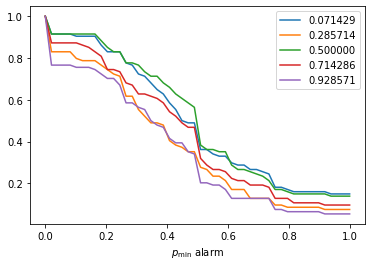

In [ ]:
for idx in range(1, len(vth_probs), 3):
  signaled = (res[:, idx].reshape(-1,1) >= np.linspace(0,1).reshape(1,-1)).mean(axis=0)
  plt.plot(np.linspace(0,1), signaled, label="%f" % vth_probs[idx])
plt.xlabel("$p_{\\rm min}$ alarm")
plt.legend()
plt.show()

In [ ]:
threshold_dist = 1e-2
probs = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
res = []
for v_th_prob in probs:
  v_thresholds = {}
  for key in excoefs.keys():
    V = np.sqrt(np.sum(excoefs[key][:2,:]**2,axis=0))
    V = V[np.isfinite(V)]
    V = np.sort(V)
    v_th_idx = int(len(V)*(1-v_th_prob))
    if(len(V) == 0):
      v_thresholds[key] = np.infty
    else:
      v_thresholds[key] = V[v_th_idx]
    #plt.plot(V,np.linspace(0,1,len(V)))
    #plt.vlines(v_thresholds[key],0,1)
    #plt.xscale('log')
    #plt.show()
    #break
  signal_prob = []
  signal_magn = []
  for cnt, (date,row) in enumerate(earthquakes.iterrows()):
    match_cnt = 0
    alert_cnt = 0
    for cnt2, key in enumerate(excoefs.keys()):
       dist = distances[cnt,cnt2]
       if(dist <= threshold_dist):
         match = np.argwhere(stat_data[key].index==date).flatten()
         if(len(match)>0):
           match = match[0]
           v_matched = np.sqrt(np.sum(excoefs[key][:,match-W:match][:2,:]**2,axis=0))
           v_matched = v_matched[np.isfinite(v_matched)]
           if(len(v_matched) == W):
             match_cnt += 1
             if(np.max(v_matched) >= v_thresholds[key]):
               alert_cnt += 1
    if(match_cnt > 0):
      signal_prob.append(alert_cnt/match_cnt)
      signal_magn.append(row["m"])
  res.append( np.array(signal_prob) )
res = np.array(res)

In [ ]:
cuts = (res[:,np.newaxis,:]>np.linspace(0,1,20).reshape(1,-1,1)).astype('int')

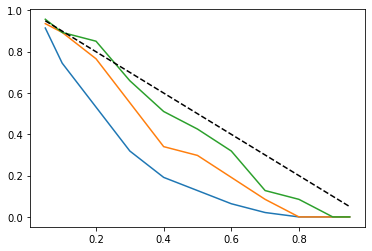

In [ ]:
plt.plot(probs, 1-cuts[:,5,:].mean(axis=-1))
plt.plot(probs, 1-cuts[:,10,:].mean(axis=-1))
plt.plot(probs, 1-cuts[:,15,:].mean(axis=-1))
plt.plot(probs,1-np.array(probs), ls='dashed', c='black')
plt.show()

In [ ]:
non_signaled = 1-cuts.sum(axis=2)/cuts.shape[2]

In [ ]:
non_signaled.shape

(11, 20)

# Pytorch

In [3]:
T_seq = 10
delta_days = np.timedelta64(T_seq, 'D')
max_distance = 5e-3
dataset = []
for cnt, (date,row) in enumerate(earthquakes.iterrows()):
  for key in stat_data.keys():
    pos = station_pos[key]
    dist = haversine(pos[0], row["lat"], pos[1]-row["long"])
    if(dist <= max_distance):
      match = stat_data[key][np.logical_and(stat_data[key].index < date,stat_data[key].index >= date - delta_days )]
      if((not match.empty) and (np.isfinite(match["N"]).all())):
        match = match[["N","E","U"]]
        if(match.shape[0] < T_seq):
          continue
        else:
          match = match.values[np.newaxis,...]
          dataset.append(match)                              
dataset = np.transpose(np.concatenate(dataset, axis=0),axes=(0,2,1))
with open("dset_false_T=%i_dist=%f.pkl" % (T_seq, max_distance), "wb") as handle:
  pkl.dump(dataset, handle)

NameError: ignored

In [4]:
with open("drive/MyDrive/Colab Notebooks/dset_false_T=%i_dist=%f.pkl" % (T_seq, max_distance), "rb") as handle:
  d_false = pkl.load(handle)
with open("drive/MyDrive/Colab Notebooks/dset_true_T=%i_dist=%f.pkl" % (T_seq, max_distance), "rb") as handle:
  d_true = pkl.load(handle)

In [11]:
data = np.concatenate([d_false, d_true], axis=0)
labels = np.concatenate([np.zeros(d_false.shape[0],dtype=int), np.ones(d_true.shape[0], dtype=int)])

In [12]:
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(np.arange(labels.shape[0]), train_size=0.7, stratify=labels, shuffle=True)

In [15]:
x_train, x_test = torch.FloatTensor(data[train_indices]), torch.FloatTensor(data[test_indices])
y_train, y_test = torch.LongTensor(labels[train_indices]), torch.LongTensor(labels[test_indices])

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class gpsnet(nn.Module):
    def __init__(self, T_seq):
        super().__init__()
        self.T_seq = T_seq
        self.conv1 = nn.Conv1d(3, 32, 3) #output is T_seq - 2
        self.conv1_sz = ((self.T_seq+2*0-1*(3-1)-1)//1+1)
        self.bnorm1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 3)
        self.bnorm2 = nn.BatchNorm1d(64)
        self.conv2_sz = ((self.conv1_sz+2*0-1*(3-1)-1)//1+1)
        self.fc1 = nn.Linear(64*self.conv2_sz, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bnorm1(F.relu(x))
        x = self.conv2(x)
        x = self.bnorm2(F.relu(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)

In [ ]:
net = gpsnet(T_seq)
batch_size = 10
weight1 = y_train.sum()/len(y_train)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
hist = []
for epoch in range(2000):  # loop over the dataset multiple times
    for i in range(0, x_train.size(0), batch_size):
        # get the inputs; data is a list of [inputs, labels]
        endpt = min(i+batch_size, x_train.size(0))
        inputs, ground_tr = x_train[i:endpt], y_train[i:endpt].to(torch.float32)
        #weight = torch.zeros(batch_size)
        #weight[ground_tr[:,0]==1] = (1-weight1)/batch_size
        #weight[ground_tr[:,0]==0] = weight1/batch_size
        #criterion.weight=weight
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(1), ground_tr)
        loss.backward()
        optimizer.step()

        if i % 1 == 0: 
            hist.append(loss.item())

print('Finished Training')

Finished Training


In [ ]:
with torch.no_grad():
  res = net(x_train)
  print(criterion(res.squeeze(1), y_train.to(torch.float32)))
  #res = net(x_train)
  #print(criterion(res, y_train.view(-1,1).to(torch.float32)))

tensor(0.4853)


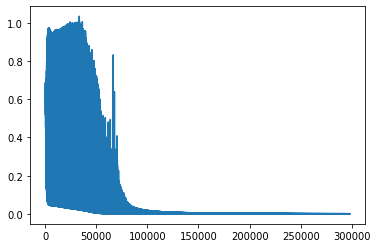

In [ ]:
plt.plot(hist)